###                                                                                         Name: Sharon Laurance Muthipeedika 
###                                                                                         Matriculation No: 312486

## Exercise 2: Gradient Boosted Decision Trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import mean_squared_error

#### 1. Generate a binary classification toy dataset from the scikit-learn utility "make-moons". Please generate 100 samples, for 10 different levels of noise which should give you a toy-dataset of 1000 samples. Here sample refers to a single point in 2-D, and it’s corresponding label (0 vs. 1) denoting membership in either of the two moons. Visualize the 10 different pairs of so-called moons.


In [2]:
X,y=make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=3116)

In [3]:
X_arr=[]
y_arr=[]
for i in range(10):
    X,y=make_moons(n_samples=100, shuffle=True, noise=(i/10), random_state=3116)
    X_arr.append(X)
    y_arr.append(y)

<Figure size 432x288 with 0 Axes>

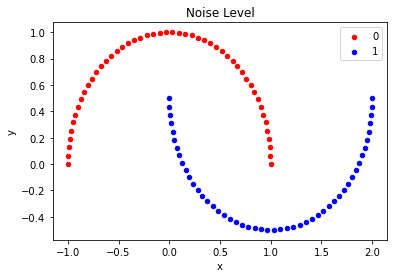

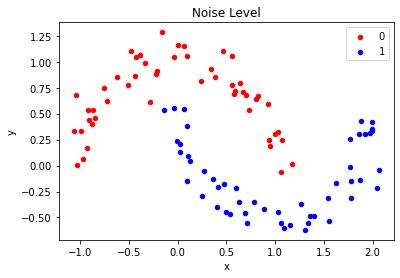

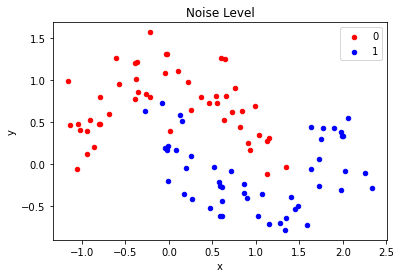

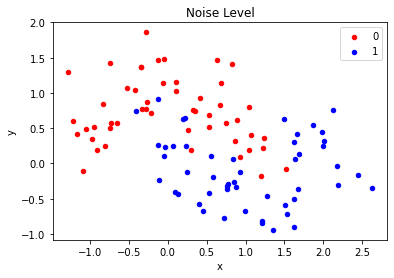

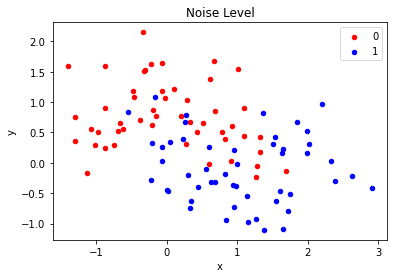

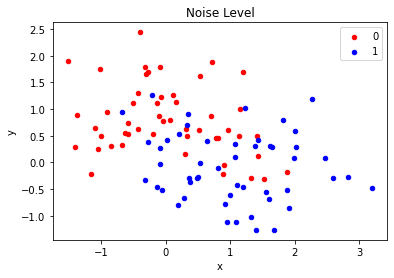

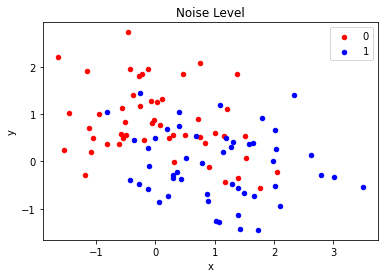

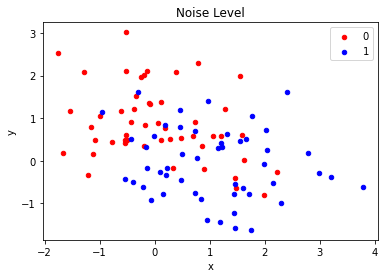

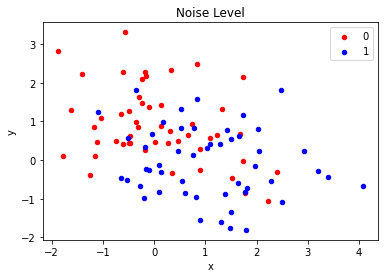

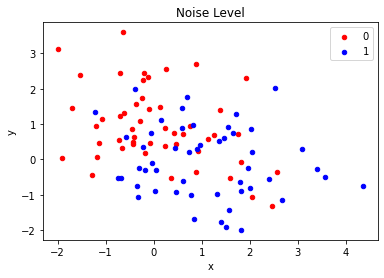

In [4]:
import matplotlib.pyplot as plt
arr_n=list(range(10))
plt.figure(0)
c=0
for i in range(10):
    df = pd.DataFrame(dict(x=X_arr[arr_n[c]][:,0], y=X_arr[arr_n[c]][:,1], label=y_arr[arr_n[c]]))
    colors = {0:'red', 1:'blue'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.title("Noise Level")
    c+=1
plt.show()

In [5]:
X=np.concatenate((X_arr[0], X_arr[1]), axis=0)
for i in range(2,10):
    X=np.concatenate((X, X_arr[i]), axis=0)

In [6]:
y=np.concatenate((y_arr[0], y_arr[1]), axis=0)
for i in range(2,10):
    y=np.concatenate((y, y_arr[i]), axis=0)

#### 2. Generate train/validation/test splits with the ratios like before.

In [7]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.15, random_state=3116)

In [8]:
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train, test_size=0.15, random_state=3116)

In [9]:
def entropy(y): #vector y of all the class labels
#     hist= np.bincount(np.array(y_train).flatten())
#     print(y)

    uniqw, inverse = np.unique(y, return_inverse=True)
    hist=np.bincount(inverse)

    ps =hist / len(y)
#     return np.sum([1 - np.max([p, 1 - p]) for p in ps if p>0])
    
    return -np.sum([p * np.log2(p) for p in ps if p>0])
    
class Node:
    
    def __init__(self, feature= None, threshold= None, left=None,right=None,*,value=None):
        
        self.feature=feature
        self.threshold=threshold
        self.left=left
        self.right=right
        self.value=value

        
    def is_leaf_node(self):
        return self.value is not None
    
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_feats=n_feats
        self.root=None
        
    def fit( self, X,y):
        #grow tree
        self.n_feats=X.shape[1] if not self.n_feats else min(self.n_feats,X.shape[1])
        
        self.root=self.grow_tree(X,y)
        
    def grow_tree(self, X, y, depth=0):
        n_samples, n_features= X.shape
        
        n_labels=len(np.unique(y))
        
        
        #Stopping criterion
        
        if (depth>=self.max_depth or n_labels==1 or n_samples< self.min_samples_split):
            
            leaf_value= self._most_common_label(y)
            
            return Node(value=leaf_value)
        
        feat_idxs= np.random.choice(n_features, self.n_feats, replace=False)
        
        #Greedy Search
        best_feat, best_thresh= self._best_criteria(X, y, feat_idxs)
        
        
        
        left_idxs, right_idxs= self._split(X[:, best_feat], best_thresh)
        
        left= self.grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        
        right= self.grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        
        return Node(best_feat, best_thresh, left, right)
    
    
        
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature), "<=", tree.threshold, "?", tree.value)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
            
    def _best_criteria(self, X, y, feat_idxs):
        
        best_gain=-1
        split_idx, split_thresh= None, None
        for feat_idx in feat_idxs:
            X_column= X[:, feat_idx]
            
            thresholds= np.unique(X_column)
            
            for threshold in thresholds:
                gain=self._information_gain(y,X_column, threshold)
                
                if (gain>best_gain):
                    best_gain=gain
                    split_idx= feat_idx
                    split_thresh= threshold
        return split_idx, split_thresh
            
    def _information_gain(self,y,X_column, split_thresh):
        #parent entropy
        parent_entropy=entropy(y)
        #generate split
        left_idxs, right_idxs= self._split(X_column, split_thresh)
        if len(left_idxs)==0 or len(right_idxs)==0:
            return 0
        #weighted avg
        n= len(y)
        n_l, n_r= len(left_idxs), len(right_idxs)
        

        e_l, e_r=entropy(y[left_idxs]), entropy(y[right_idxs])
        
        child_entropy= (n_l/n)* e_l+(n_r/n)* e_r
        
        #information gain
        ig=parent_entropy-child_entropy

        return ig
        
    def _split(self, X_column, split_thresh):

        left_idxs= np.argwhere(np.array(X_column)<= split_thresh).flatten()
        
        right_idxs= np.argwhere(np.array(X_column)> split_thresh).flatten()
        
        return left_idxs,right_idxs
 
    def _most_common_label(self, y):

        counter=Counter(y)
        
        most_common=counter.most_common(1)[0][0]
        return most_common
                
    def predict(self, X):
        #traverse tree

        return np.array([self._traverse_tree(x , self.root) for x in X])
    
    def _traverse_tree(self, x , node):

        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <=node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
  
def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy
          

In [10]:
class GradientBoosting():
    
    def __init__(self, n_trees, learning_rate, max_depth=2):
        self.n_trees=n_trees; self.learning_rate=learning_rate; self.max_depth=max_depth;
        
    def fit(self, x, y):
        self.trees = []
        self.F0 = y.mean()
        Fm = self.F0 

        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(x, y - Fm)
            
            Fm += self.learning_rate * tree.predict(x)

            self.trees.append(tree)
            
    def predict(self, x):
        return self.F0 + self.learning_rate * np.sum([tree.predict(x) for tree in self.trees], axis=0)

#### 3. Please keep max depth of trees to 2 i.e root node then leaf nodes (also called stumps), and tune number of trees in the ensemble on the validation set.


In [11]:
#Hyperparameter Tuning to find the best number of tress
n_tress_arr=[20,25,30,35]
error_dict={}
for i in n_tress_arr:
    gradient_boosting = GradientBoosting(n_trees=i, learning_rate=0.3, max_depth=2)
    gradient_boosting.fit(X_train,y_train)
    error=mean_squared_error(y_val, gradient_boosting.predict(X_val))
    error_dict[i]=error

In [12]:
error_dict

{20: 0.20296294310995022,
 25: 0.20309774082541615,
 30: 0.2031204179213686,
 35: 0.20312422987227222}

#### 4. Report test-accuracy.

In [14]:
gradient_boosting = GradientBoosting(n_trees=20, learning_rate=0.3, max_depth=2)
gradient_boosting.fit(X_train,y_train)
error=mean_squared_error(y_val, gradient_boosting.predict(X_val))
print("Error on Validation Set is", error)

Error on Validation Set is 0.20296294310995022


In [15]:
error_test=mean_squared_error(y_test, gradient_boosting.predict(X_test))
print("Error on Test Set is", error_test)

Error on Test Set is 0.15321104129744914


#### References
 - https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/
 - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
 - https://stackoverflow.com/questions/10119441/numpy-bincount-with-floats
 - https://blog.mattbowers.dev/gradient-boosting-machine-from-scratch